<a href="https://colab.research.google.com/github/eluyutao/MMAI-Deep-Learning-Projects/blob/main/Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install emot
! pip install transformers
! pip install keras_tuner
! pip install tensorflow_addons
! pip install tensorflow-hub

     |████████████████████████████████| 61 kB 23 kB/s 
     |████████████████████████████████| 3.8 MB 29.0 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 895 kB 53.6 MB/s 
     |████████████████████████████████| 6.5 MB 61.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 133 kB 28.6 MB/s 
     |████████████████████████████████| 1.1 MB 27.9 MB/s 


In [4]:
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

In [5]:
import pandas as pd
import matplotlib
import emot, re
from sklearn.model_selection import train_test_split
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO

from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, LSTM, Embedding, Bidirectional
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig

import keras_tuner as kt
import keras.backend as K
from tensorflow import keras
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import tensorflow_hub as hub

pd.set_option("display.max_columns", 99)

In [6]:
! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
! wget data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv
goemotions_1 = pd.read_csv('goemotions_1.csv')
goemotions_2 = pd.read_csv('goemotions_2.csv')
goemotions_3 = pd.read_csv('goemotions_3.csv')
frames = [goemotions_1, goemotions_2, goemotions_3]
df = pd.concat(frames, ignore_index=True)

--2022-03-27 01:52:23--  http://data/full_dataset/
Resolving data (data)... failed: No address associated with hostname.
wget: unable to resolve host address ‘data’
--2022-03-27 01:52:23--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.128, 142.250.188.48, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  45.0MB/s    in 0.3s    

2022-03-27 01:52:23 (45.0 MB/s) - ‘goemotions_1.csv’ saved [14174600/14174600]

FINISHED --2022-03-27 01:52:23--
Total wall clock time: 0.5s
Downloaded: 1 files, 14M in 0.3s (45.0 MB/s)
--2022-03-27 01:52:23--  http://data/full_dataset/
Resolving data (data)... failed: No address associated with hostna

In [7]:
print(df.shape)
df.head(2)

(211225, 37)


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
df.example_very_unclear.value_counts()

False    207814
True       3411
Name: example_very_unclear, dtype: int64

In [9]:
%%time
# emotion label columns
lb_col = df.columns[9:]
print(f'Entire dataset: {df.shape}')
# remove examples that were very unclear. They do not have any emotions labels
df2 = df[~df['example_very_unclear']].copy()
print(f'{df2.shape[0]} rows left after removing records with unclear emotions')
# Sum the emotions together because there are different raters
df2 = df2[['text']+list(lb_col)].groupby(['text']).sum().reset_index()
print(f'{df2.shape[0]} rows left after deduping on text and id columns')
# keep records where there are at least two agreeing emotion labels
df2['at_least_2_agree'] = df2[lb_col].apply(lambda x: x.max(), axis=1)
df2 = df2[df2.at_least_2_agree >= 2]
print(df2.at_least_2_agree.unique())

Entire dataset: (211225, 37)
207814 rows left after removing records with unclear emotions
57730 rows left after deduping on text and id columns
[ 2  3  4  5  7  6 12 13 14  8 17  9 10 15 33 11 45 22]
CPU times: user 3.74 s, sys: 504 ms, total: 4.24 s
Wall time: 5.49 s


In [10]:
for col in df2.columns[1:]:
    df2[col] = df2[col].apply(lambda x: 0 if x <= 1 else 1)

df_clean = df2.drop('at_least_2_agree', axis=1)
print(f'{df2.shape[0]} rows left after removing records without having at least two raters agreeing on the emotion')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


53994 rows left after removing records without having at least two raters agreeing on the emotion


In [11]:
print(df_clean.shape)
df_clean.head(2)

(53994, 29)


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [12]:
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        if emot in text:
            orig = text
            text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
            # print(f'{orig} -> {text}', '\n')
    return text

def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        if emot in text:
            orig = text
            text = text.replace(emot, "_".join(EMOTICONS_EMO[emot].split()))
            # print(f'{orig} -> {text}', '\n')
    return text

In [13]:
%%time
print('-------replacing emoji with text---------')
df_clean['text'] = df_clean['text'].apply(lambda x: convert_emojis(x))
print('-------replacing emoticon with text---------')
df_clean['text'] = df_clean['text'].apply(lambda x: convert_emoticons(x))

-------replacing emoji with text---------
-------replacing emoticon with text---------
CPU times: user 8.32 s, sys: 16.5 ms, total: 8.33 s
Wall time: 8.36 s


In [14]:
X = df_clean['text']
y = df_clean.iloc[:,1:]
y.head(2)

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=2)
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_val shape: {Y_val.shape}')
print(f'Y_test shape: {Y_test.shape}')

X_train shape: (43195,)
X_val shape: (5399,)
X_test shape: (5400,)
Y_train shape: (43195, 28)
Y_val shape: (5399, 28)
Y_test shape: (5400, 28)


In [16]:
X_test_orig = X_test.copy()

## Word Embedding

In [17]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 64
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='', lower=True)
tokenizer.fit_on_texts(X_train.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 49290 unique tokens.


In [18]:
def embedding(text, tokenizer):
    MAX_SEQUENCE_LENGTH = 64
    text = tokenizer.texts_to_sequences(text.values)
    text = pad_sequences(text, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    print('Shape of data tensor:', text.shape)
    return text

In [19]:
X_train = embedding(X_train, tokenizer)
X_val = embedding(X_val, tokenizer)
X_test = embedding(X_test, tokenizer)
# Y_train = embedding(Y_train)
# Y_val = embedding(Y_val)
# Y_test = embedding(Y_test)

Shape of data tensor: (43195, 64)
Shape of data tensor: (5399, 64)
Shape of data tensor: (5400, 64)


## Build Model

In [20]:
def calculating_class_weights(Y_train):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(Y_train)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight(class_weight = 'balanced', 
                                          classes = np.unique(Y_train.iloc[:, i]), 
                                          y = Y_train.iloc[:, i])
    return weights

In [21]:
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

In [22]:
np.bincount(Y_train.iloc[:, 2])

array([41586,  1609])

In [23]:
class_weights = calculating_class_weights(Y_train)

In [24]:
def build_model():
    # TODO: build the model, 
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    initial_weights = keras.initializers.GlorotNormal(seed=112)
    
    model=Sequential()
    model.add(Embedding(MAX_NB_WORDS,100,input_length=MAX_SEQUENCE_LENGTH))
    # model.add(Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.2)))
    # model.add(Bidirectional(LSTM(units=64, return_sequences=False, dropout=0.2))) 
    # model.add(Flatten())
    # hp_units_1 = hp.Int('units1', min_value=32, max_value=32, step=32)
    model.add(LSTM(128,input_shape=(64,),activation='relu', return_sequences=True))
    # hp_units_2 = hp.Int('units2', min_value=32, max_value=32, step=32)
    model.add(LSTM(64,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(28,
                    activation='sigmoid',
                    kernel_initializer=initial_weights))

    print(model.summary())
    return model

def compile_model(model):
    # TODO: compile the model
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    metrics = [tfa.metrics.HammingLoss(mode='multiclass', name='hamming-mc', dtype=tf.float32, threshold=0.2),
                tfa.metrics.HammingLoss(mode='multilabel', name='hamming-ml', dtype=tf.float32, threshold=0.4),
                keras.metrics.CategoricalCrossentropy('Cat-CE', dtype=tf.float32),
                keras.metrics.BinaryCrossentropy('Bin-CE', dtype=tf.float32, label_smoothing=0.5),
                keras.metrics.CategoricalAccuracy()]
    opt = keras.optimizers.SGD(learning_rate=0.0001)
    
    model.compile(loss=get_weighted_loss(class_weights), optimizer=opt, metrics=keras.metrics.CategoricalAccuracy())
    return model

def train_model(model, X_train, Y_train, X_val, Y_val):
    # TODO: train the model
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    # from sklearn.utils import compute_class_weight
    # classWeight = compute_class_weight('balanced', outputLabels, outputs) 

    history = model.fit(
        X_train,
        Y_train,
        batch_size=32,
        epochs=5,
        verbose=2,
        validation_data=(X_val, Y_val))

    return model, history


def eval_model(model, X_test, Y_test):
    # TODO: evaluate the model
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    test_loss, test_accuracy = model.evaluate(X_test, Y_test)
    return test_loss, test_accuracy

In [25]:
model = build_model()
model = compile_model(model)
model, history = train_model(model, X_train, Y_train, X_val, Y_val)
# test_loss, test_accuracy = eval_model(model, X_test, Y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 100)           500000    
                                                                 
 lstm (LSTM)                 (None, 64, 128)           117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

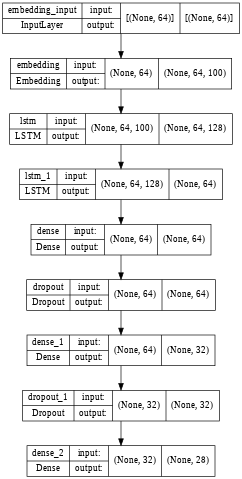

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

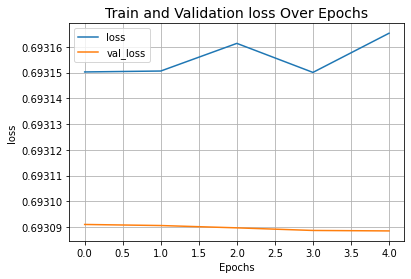

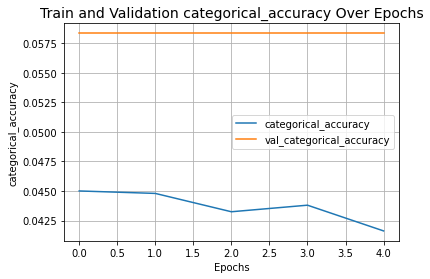

In [27]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

## Inference

In [28]:
def find_label(i):
  record_label = []
  for col in Y_test:
    if Y_test.loc[i, col] == 1:
      record_label.append(col)
  return record_label

In [29]:
# Create a small dataset just for demoing inference.
inference_dataset = X_test_orig.sample(5, random_state=1)
X_test_emb = embedding(inference_dataset, tokenizer)
predicted_probabilities = model.predict(X_test_emb)
pred_df = pd.DataFrame(predicted_probabilities, index=inference_dataset.index, columns=lb_col).T
# Perform inference.
for i, text in inference_dataset.iteritems():
    label = find_label(i)
    print(f"Text: {text}")
    print(f"  Label(s): {label}")
    predicted_proba = pred_df[i].sort_values(ascending=False)
    print(f"Predicted Label(s): \n{predicted_proba}")
    print(" ")

Shape of data tensor: (5, 64)
Text: Be Advised “stay away from alcohol” Focus on the kids Do not engage on a campaign for justice Get well soon bro.
  Label(s): ['caring']
Predicted Label(s): 
approval          0.502963
disapproval       0.502435
desire            0.501843
gratitude         0.501755
fear              0.501470
pride             0.501397
neutral           0.501005
realization       0.500948
disappointment    0.500742
excitement        0.500481
joy               0.500046
sadness           0.500018
optimism          0.499948
disgust           0.499876
love              0.499826
admiration        0.499616
anger             0.499291
confusion         0.499028
curiosity         0.498935
amusement         0.498836
caring            0.498755
grief             0.498617
surprise          0.498614
embarrassment     0.498408
annoyance         0.498397
relief            0.498388
remorse           0.498303
nervousness       0.497396
Name: 4648, dtype: float32
 
Text: Welcome to the c

In [30]:
# inference_dataset = X_test_orig.sample(5, random_state=1)
# X_test_emb = embedding(inference_dataset, tokenizer)
predicted_probabilities = model.predict(X_test)
prd = pd.DataFrame(predicted_probabilities, index=X_test_orig.index, columns=lb_col)
prd['max_emotion'] = prd.idxmax(axis=1)
prd.head(2)

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,max_emotion
25597,0.499616,0.498836,0.499291,0.498397,0.502964,0.498755,0.499028,0.498935,0.501843,0.500742,0.502435,0.499876,0.498408,0.500481,0.50147,0.501755,0.498617,0.500046,0.499826,0.497396,0.499948,0.501397,0.500948,0.498388,0.498303,0.500018,0.498614,0.501005,approval
26413,0.499616,0.498836,0.499291,0.498397,0.502963,0.498755,0.499027,0.498935,0.501843,0.500742,0.502435,0.499875,0.498408,0.500481,0.50147,0.501755,0.498618,0.500046,0.499826,0.497396,0.499948,0.501397,0.500948,0.498387,0.498303,0.500018,0.498614,0.501005,approval


In [31]:
prd.max_emotion.value_counts()

approval    5400
Name: max_emotion, dtype: int64

## Evaluating Model

In [32]:
def eval_model(model, X_test, label):

    test_scores = model.evaluate(x = X_test,
                        y = label, verbose=2)
    test_loss = test_scores[0]
    test_metrics = test_scores[1]
    print("Test loss:", test_loss)
    print("Test accuracy:", test_metrics)

    return test_loss, test_metrics

test_loss, test_metrics = eval_model(model, X_test, Y_test)

169/169 - 5s - loss: 0.7001 - categorical_accuracy: 0.0563 - 5s/epoch - 27ms/step
Test loss: 0.7001113295555115
Test accuracy: 0.056296296417713165


In [33]:
# test_df = pd.DataFrame()
# labels = []
# predicts = []
# iteration = []
#   #print(i, ":\t", label[i].argmax(), "\n\t", predictions[i].argmax())
# test_df['Labels'] = labels
# test_df['Predictions'] = predicts
# test_df['Iteration'] = iteration

In [34]:
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

In [35]:
metric2 = tfa.metrics.HammingLoss(mode='multiclass', threshold=0.2)
labels = Y_test
predicts = predicted_probabilities
y_true = tf.convert_to_tensor(labels, dtype=tf.float32)
y_pred = tf.convert_to_tensor(predicts, dtype=tf.float32)

metric2.update_state(y_true, y_pred)
print("Hamming distance: ", metric2.result().numpy())

metric3 = tf.keras.metrics.KLDivergence()
metric3.update_state(y_true, y_pred)
print("\nKL Divergence: ", metric3.result().numpy())

metric4 = tf.keras.metrics.Accuracy()
metric4.update_state(y_true, y_pred)
print("\nAccuracy: ", metric4.result().numpy())

metric6 = tfa.metrics.F1Score(num_classes=28, threshold=0.5)
metric6.update_state(y_true, y_pred)
print("\nF1 Score: ", metric6.result().numpy())

metric7 = tf.keras.metrics.SensitivityAtSpecificity(0.85)
metric7.update_state(y_true, y_pred)
print("\nSensitivity: ", metric7.result().numpy())

metric8 = multi_label_accuracy(y_true, y_pred)
#assert metric8.shape == (2,)
print("\nMulti-label Accuracy: ", metric8)

metric5 = tfa.metrics.MultiLabelConfusionMatrix(num_classes=28)
metric5.update_state(y_true, y_pred)
print("\nMulti-label Confusion Matrices: \n", metric5.result().numpy())

Hamming distance:  -0.1762963

KL Divergence:  0.8144428

Accuracy:  0.0

F1 Score:  [0.         0.         0.         0.         0.12043162 0.
 0.         0.         0.03350328 0.05825243 0.09624537 0.
 0.         0.04134929 0.03063458 0.12206572 0.         0.06901484
 0.         0.         0.         0.00554017 0.04241436 0.
 0.         0.05054152 0.         0.48122627]

Sensitivity:  0.054471035

Multi-label Accuracy:  tf.Tensor(0.0, shape=(), dtype=float32)

Multi-label Confusion Matrices: 
 [[[4871.    0.]
  [ 529.    0.]]

 [[5121.    0.]
  [ 279.    0.]]

 [[5218.    0.]
  [ 182.    0.]]

 [[5110.    0.]
  [ 290.    0.]]

 [[5054.    0.]
  [ 346.    0.]]

 [[5255.    0.]
  [ 145.    0.]]

 [[5212.    0.]
  [ 188.    0.]]

 [[5104.    0.]
  [ 296.    0.]]

 [[5308.    0.]
  [  92.    0.]]

 [[5238.    0.]
  [ 162.    0.]]

 [[5127.    0.]
  [ 273.    0.]]

 [[5288.    0.]
  [ 112.    0.]]

 [[5359.    0.]
  [  41.    0.]]

 [[5286.    0.]
  [ 114.    0.]]

 [[5316.    0.]
  [  84